<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Product-Quantization-for-Model-Compression" data-toc-modified-id="Product-Quantization-for-Model-Compression-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Product Quantization for Model Compression</a></span><ul class="toc-item"><li><span><a href="#Data-Preparation-and-Model" data-toc-modified-id="Data-Preparation-and-Model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Preparation and Model</a></span></li><li><span><a href="#Product-Quantization-from-Scratch" data-toc-modified-id="Product-Quantization-from-Scratch-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Product Quantization from Scratch</a></span><ul class="toc-item"><li><span><a href="#Learning-Code-Book" data-toc-modified-id="Learning-Code-Book-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Learning Code Book</a></span></li><li><span><a href="#Encode" data-toc-modified-id="Encode-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Encode</a></span></li></ul></li><li><span><a href="#Computing-Query-Distance" data-toc-modified-id="Computing-Query-Distance-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Computing Query Distance</a></span></li><li><span><a href="#Fasttext-Product-Quantization" data-toc-modified-id="Fasttext-Product-Quantization-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Fasttext Product Quantization</a></span></li><li><span><a href="#Product-Quantization-Recap" data-toc-modified-id="Product-Quantization-Recap-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Product Quantization Recap</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', '..', 'notebook_format'))

from formats import load_style
load_style(plot_style=False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import time
import fasttext
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# prevent scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,fasttext,scipy

Ethen 2020-05-21 22:08:36 

CPython 3.6.4
IPython 7.9.0

numpy 1.16.5
pandas 0.25.0
matplotlib 3.1.1
fasttext n
scipy 1.4.1


# Product Quantization for Model Compression

**Product Quantization** or often times PQ for short is an extremely popular algorithm for compressing vectors/embeddings and performing approximate nearest neighborhood search. In this example, we'll be using fasttext to illustrate the concept. The library and the data preparation step has already been introduced in another [documentation](http://ethen8181.github.io/machine-learning/deep_learning/multi_label/fasttext.html), hence we won't be spending too much on them.

## Data Preparation and Model

In [3]:
# download the data and un-tar it under the 'data' folder

# -P or --directory-prefix specifies which directory to download the data to
!wget https://dl.fbaipublicfiles.com/fasttext/data/cooking.stackexchange.tar.gz -P data
# -C specifies the target directory to extract an archive to
!tar xvzf data/cooking.stackexchange.tar.gz -C data

--2020-05-21 22:08:36--  https://dl.fbaipublicfiles.com/fasttext/data/cooking.stackexchange.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 457609 (447K) [application/x-tar]
Saving to: ‘data/cooking.stackexchange.tar.gz.3’

cooking.stackexchan 100%[===================>] 446.88K  --.-KB/s    in 0.1s    

2020-05-21 22:08:36 (4.43 MB/s) - ‘data/cooking.stackexchange.tar.gz.3’ saved [457609/457609]

x cooking.stackexchange.id
x cooking.stackexchange.txt
x readme.txt


In [4]:
!head -n 3 data/cooking.stackexchange.txt

__label__sauce __label__cheese How much does potato starch affect a cheese sauce recipe?
__label__food-safety __label__acidity Dangerous pathogens capable of growing in acidic environments
__label__cast-iron __label__stove How do I cover up the white spots on my cast iron stove?


In [5]:
# train/test split
from fasttext_module.split import train_test_split_file
from fasttext_module.utils import prepend_file_name

data_dir = 'data'
test_size = 0.2
input_path = os.path.join(data_dir, 'cooking.stackexchange.txt')
input_path_train = prepend_file_name(input_path, 'train')
input_path_test = prepend_file_name(input_path, 'test')
random_state = 1234
encoding = 'utf-8'

train_test_split_file(input_path, input_path_train, input_path_test,
                      test_size, random_state, encoding)
print('train path: ', input_path_train)
print('test path: ', input_path_test)

train path:  data/train_cooking.stackexchange.txt
test path:  data/test_cooking.stackexchange.txt


In [6]:
# train the fasttext model
fasttext_params = {
    'input': input_path_train,
    'lr': 0.1,
    'lrUpdateRate': 1000,
    'thread': 8,
    'epoch': 15,
    'wordNgrams': 1,
    'dim': 80,
    'loss': 'ova'
}
model = fasttext.train_supervised(**fasttext_params)

print('vocab size: ', len(model.words))
print('label size: ', len(model.labels))
print('example vocab: ', model.words[:5])
print('example label: ', model.labels[:5])

model_checkpoint = os.path.join('model', 'model.fasttext')
model.save_model(model_checkpoint)

vocab size:  14496
label size:  733
example vocab:  ['</s>', 'to', 'a', 'How', 'the']
example label:  ['__label__baking', '__label__food-safety', '__label__substitutions', '__label__equipment', '__label__bread']


In [7]:
# model.get_input_matrix().shape
print('output matrix shape: ', model.get_output_matrix().shape)
model.get_output_matrix()

output matrix shape:  (733, 80)


array([[ 0.7556045 , -0.0944011 , -0.21562839, ..., -2.333261  ,
        -0.8223824 ,  1.4007478 ],
       [ 0.8890684 , -0.35554123, -2.706871  , ...,  1.2450662 ,
         0.05990526, -2.0757916 ],
       [ 0.40264592, -1.7393613 ,  1.3168088 , ..., -3.8272636 ,
         1.9295563 ,  1.6614803 ],
       ...,
       [ 1.0975604 , -0.8535318 ,  0.24365285, ..., -0.5385103 ,
        -0.5356003 ,  0.6660056 ],
       [ 1.1728309 , -0.92786735,  0.30251437, ..., -0.60272974,
        -0.5144258 ,  0.7182006 ],
       [ 1.1421866 , -0.89937526,  0.29751846, ..., -0.6316411 ,
        -0.570792  ,  0.7465125 ]], dtype=float32)

## Product Quantization from Scratch

The main goal behind compression is that after training our model, the model size is too large for deployment. e.g. when deploying on edge devices where we have limited memory at hand or would require using a bigger machine which ultimately incur more infrastructure costs. 

In this situation, **product quantization** is a compression technique for compressing embeddings. It has been shown that it significantly reduce the size of the model without hurting the performance by much. And without further a due, we'll dive right into how this technique works.

### Learning Code Book

Our first step is to split the a $d$ dimensional vectors/matrix $\mathbf{X}$ into $m$ distinct subvectors $u_j$, $1 \leq j \leq m$ of dimension $d^* = d / m$, where $d$ should ideally be multiple of $m$.

As an example, say our original embedding has a dimension of 1000x80, we can split it into 4 subvectors, each having a dimension of 1000x20.

<img src="img/matrix_to_subvectors.png" width="40%" height="40%">

Next, we'll run a k-means clustering algorithm on each subvectors. Upon computing the cluster centroid for each of $k$ cluster and $m$ subvectors, we would have on our hand, $m$ cluster centroids, each of size $k \times d^*$. In other words, reducing the dimension from $n \times d$ into $m \times k \times d^* = k \times d$

<img src="img/subvectors_kmeans.png" width="50%" height="50%">

So we'll apply k-means on our 1000x20 subvectors. If $k$ is 10, we would end up having 10 cluster centroids each of size 20. Since we have 4 subvectors, we would have 4 of those.

Information theory nomenclature is often times used to explain these concepts. Where:

- The cluster centroids is referred to as **codebook**.
- The cluster index is called a **code**, a **reproduction value**, a **reconstruction value**.

We'll be using [scipy vector quantization module's k-means clustering](https://docs.scipy.org/doc/scipy/reference/cluster.vq.html) implementation in the example code.

In [8]:
from scipy.cluster.vq import kmeans2, vq


def compute_code_books(vectors, sub_size=2, n_cluster=128, n_iter=20, minit='points', seed=123):
    n_rows, n_cols = vectors.shape
    n_sub_cols = n_cols // sub_size

    np.random.seed(seed)
    code_books = np.zeros((sub_size, n_cluster, n_sub_cols), dtype=np.float32)
    for subspace in range(sub_size):
        sub_vectors = vectors[:, subspace * n_sub_cols:(subspace + 1) * n_sub_cols]
        centroid, label = kmeans2(sub_vectors, n_cluster, n_iter, minit=minit)
        code_books[subspace] = centroid

    return code_books

In [9]:
sub_size = 2  # m
n_cluster = 64  # k

# learning the cluster centroids / code books for our output matrix/embedding
code_books = compute_code_books(model.get_output_matrix(), sub_size, n_cluster)
print('code book size: ', code_books.shape)

code book size:  (2, 64, 40)


### Encode

The cluster centroids for each of the subvectors represents the average/common pattern of each subvectors, and what we're going to do is to replace the original vector with the cluster centroid of each subvectors. The effect of doing so is instead of storing the original floating values for every record in our dataset, we'll be replacing it with the closest cluster centroid id within each subvectors.

i.e. At the end, we'll be "compressing" our original vector of size $n \times d$ into a size of $n \times m$

<img src="img/product_quantization_encode.png" width="70%" height="70%">

In [10]:
def encode(vectors, code_books):
    n_rows, n_cols = vectors.shape
    sub_size = code_books.shape[0]
    n_sub_cols = n_cols // sub_size

    codes = np.zeros((n_rows, sub_size), dtype=np.int32)
    for subspace in range(sub_size):
        sub_vectors = vectors[:, subspace * n_sub_cols:(subspace + 1) * n_sub_cols]
        code, dist = vq(sub_vectors, code_books[subspace])
        codes[:, subspace] = code

    return codes

In [11]:
# our original embedding now becomes the cluster centroid for each subspace
vector_codes = encode(model.get_output_matrix(), code_books)
print('encoded vector codes size: ', vector_codes.shape)
vector_codes

encoded vector codes size:  (733, 2)


array([[34, 61],
       [29, 19],
       [ 7,  4],
       ...,
       [42, 52],
       [42, 47],
       [42, 52]], dtype=int32)

We can calculate the potential size/memory savings if we were to go from storing the original vector into storing the encoded codes and the code book.

In [12]:
(vector_codes.nbytes + code_books.nbytes) / model.get_output_matrix().nbytes

0.11231241473396998

Instead of directly compressing the original embedding, we can also learn the codebooks and compress all new incoming embeddings on the fly.

## Computing Query Distance

We can also compute nearest neighbors using the compressed vectors.

In [13]:
# we'll get one of the labels to find its nearest neighbors 
label_id = 0
print(model.labels[label_id])

query = model.get_output_matrix()[label_id]
query.shape

__label__baking


(80,)

In [14]:
# printing out the shape of the code book to hopefully make it easier
code_books.shape

(2, 64, 40)

To do so, we'll be computing the distance between each subspace of the query with the cluster centroid of each subspace, giving us a $m \times k$ distance table, where each one denotes the squared Euclidean distance between the $m_{th}$ subvector of the query and the $k_{th}$ code/cluster centroid for that $m_{th}$ subvector.

In [15]:
def query_dist_table(query, code_books):
    sub_size, n_cluster, n_sub_cols = code_books.shape

    dist_table = np.zeros((sub_size, n_cluster))
    for subspace in range(sub_size):
        sub_query = query[subspace * n_sub_cols:(subspace + 1) * n_sub_cols]

        diff = code_books[subspace] - sub_query.reshape(1, -1)
        diff = np.sum(diff ** 2, axis=1)
        dist_table[subspace, :] = diff

    return dist_table

In [16]:
dist_table = query_dist_table(query, code_books)
print(dist_table.shape)
dist_table[:, :5]

(2, 64)


array([[ 99.99280548,  67.29737854, 127.93981934, 110.84047699,
        128.75978088],
       [108.44404602, 209.63134766,  87.0813446 , 129.2036438 ,
        158.81433105]])

Then assuming for original vector is already encoded in advance, we can lookup the distances for each cluster centroid and add them up.

In [17]:
# lookup the distance
dists = np.sum(dist_table[range(sub_size), vector_codes], axis=1)
dists[:5]

array([ 42.44870567, 408.77243042, 256.50379944, 247.31576538,
       172.66897583])

In [18]:
# the numpy indexing trick is equivalent to the following loop approach
n_rows = vector_codes.shape[0]
dists = np.zeros(n_rows).astype(np.float32)
for n in range(n_rows):
    for m in range(sub_size):
        dists[n] += dist_table[m][vector_codes[n][m]]

dists[:5]

array([ 42.448708, 408.77243 , 256.50378 , 247.31577 , 172.66898 ],
      dtype=float32)

In [19]:
# find the nearest neighbors and "translate" it to the original labels
k = 5
nearest = np.argsort(dists)[:k]
[model.labels[label] for label in nearest]

['__label__baking',
 '__label__cake',
 '__label__baking-powder',
 '__label__baking-soda',
 '__label__cookies']

The approach illustrated here is more of a naive approach as it still involves calculating the distances to all the vectors, which can still be inefficient for large $n$ (number of data points). We won't be discussing how to speed up the nearest neighborhood search process for product quantization as this documentation is more focused on the compression aspect of it.

## Fasttext Product Quantization

Fasttext comes with built-in capabilities for doing model compression using product quantization. We'll experiment with different options/parameter and measure the model performance and model size. i.e. compression ratio v.s. model performance dip.

The next couple of code chunks defines the functions to measure the model performance and model file size.

In [20]:
from typing import Dict


def score(input_path_train: str,
          input_path_test: str,
          model: fasttext.FastText._FastText,
          k: int,
          round_digits: int=3) -> Dict[str, float]:

    file_path_dict = {
        'train': input_path_train,
        'test': input_path_test
    }

    result = {}
    for group, file_path in file_path_dict.items():
        num_records, precision_at_k, recall_at_k = model.test(file_path, k)
        f1_at_k = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)
        metric = {
            f'{group}_precision@{k}': round(precision_at_k, round_digits),
            f'{group}_recall@{k}': round(recall_at_k, round_digits),
            f'{group}_f1@{k}': round(f1_at_k, round_digits)
        }
        result.update(metric)

    return result

In [21]:
k = 1
result = score(input_path_train, input_path_test, model, k)
result

{'train_precision@1': 0.638,
 'train_recall@1': 0.277,
 'train_f1@1': 0.386,
 'test_precision@1': 0.489,
 'test_recall@1': 0.211,
 'test_f1@1': 0.295}

In [22]:
def compute_file_size(file_path: str) -> str:
    """
    Calculate the file size and format it into a human readable string.

    References
    ----------
    https://stackoverflow.com/questions/2104080/how-can-i-check-file-size-in-python
    """
    file_size = compute_raw_file_size(file_path)
    file_size_str = convert_bytes(file_size)
    return file_size_str


def compute_raw_file_size(file_path: str) -> int:
    """Calculate the file size in bytes."""
    file_info = os.stat(file_path)
    return file_info.st_size


def convert_bytes(num: int) -> str:
    """Convert bytes into more human readable MB, GB, etc."""
    for unit in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if num < 1024.0:
            return "%3.1f %s" % (num, unit)
        num /= 1024.0

In [23]:
compute_file_size(model_checkpoint)

'4.9 MB'

For this part of the experiment, we'll tweak the parameter, dimension of subvector, `dsub`. Remember that this is one of main parameter that controls the tradeoff between the compression ratio and amount of distortion (deviation from the original vector).

In [24]:
dsubs = [-1, 2, 4, 8]

results = []
for dsub in dsubs:
    # ensure we are always loading from the original model,
    # i.e. do not over-ride the model_checkpoint variable
    fasttext_model = fasttext.load_model(model_checkpoint)
    if dsub > 0:
        dir_name = os.path.dirname(model_checkpoint)
        model_path = os.path.join(dir_name, f'model_quantized_dsub{dsub}.fasttext')

        # qnorm, normalized the vector and quantize it
        fasttext_model.quantize(dsub=dsub, qnorm=True)
        fasttext_model.save_model(model_path)
    else:
        model_path = model_checkpoint

    result = score(input_path_train, input_path_test, fasttext_model, k)
    result['dsub'] = dsub
    result['file_size'] = compute_raw_file_size(model_path)
    results.append(result)
    
df_results = pd.DataFrame.from_dict(results)
df_results

,train_precision@1,train_recall@1,train_f1@1,test_precision@1,test_recall@1,test_f1@1,dsub,file_size
0,0.638,0.277,0.386,0.489,0.211,0.295,-1,5143093
1,0.638,0.277,0.386,0.487,0.210,0.294,2,1181690
2,0.630,0.274,0.381,0.483,0.209,0.291,4,891770
3,0.587,0.255,0.355,0.470,0.203,0.283,8,746810


We can visualize the table results. Our main observation is that setting `dsub` to 2 seems to give the most memory reduction while preserving most of the model's performance.

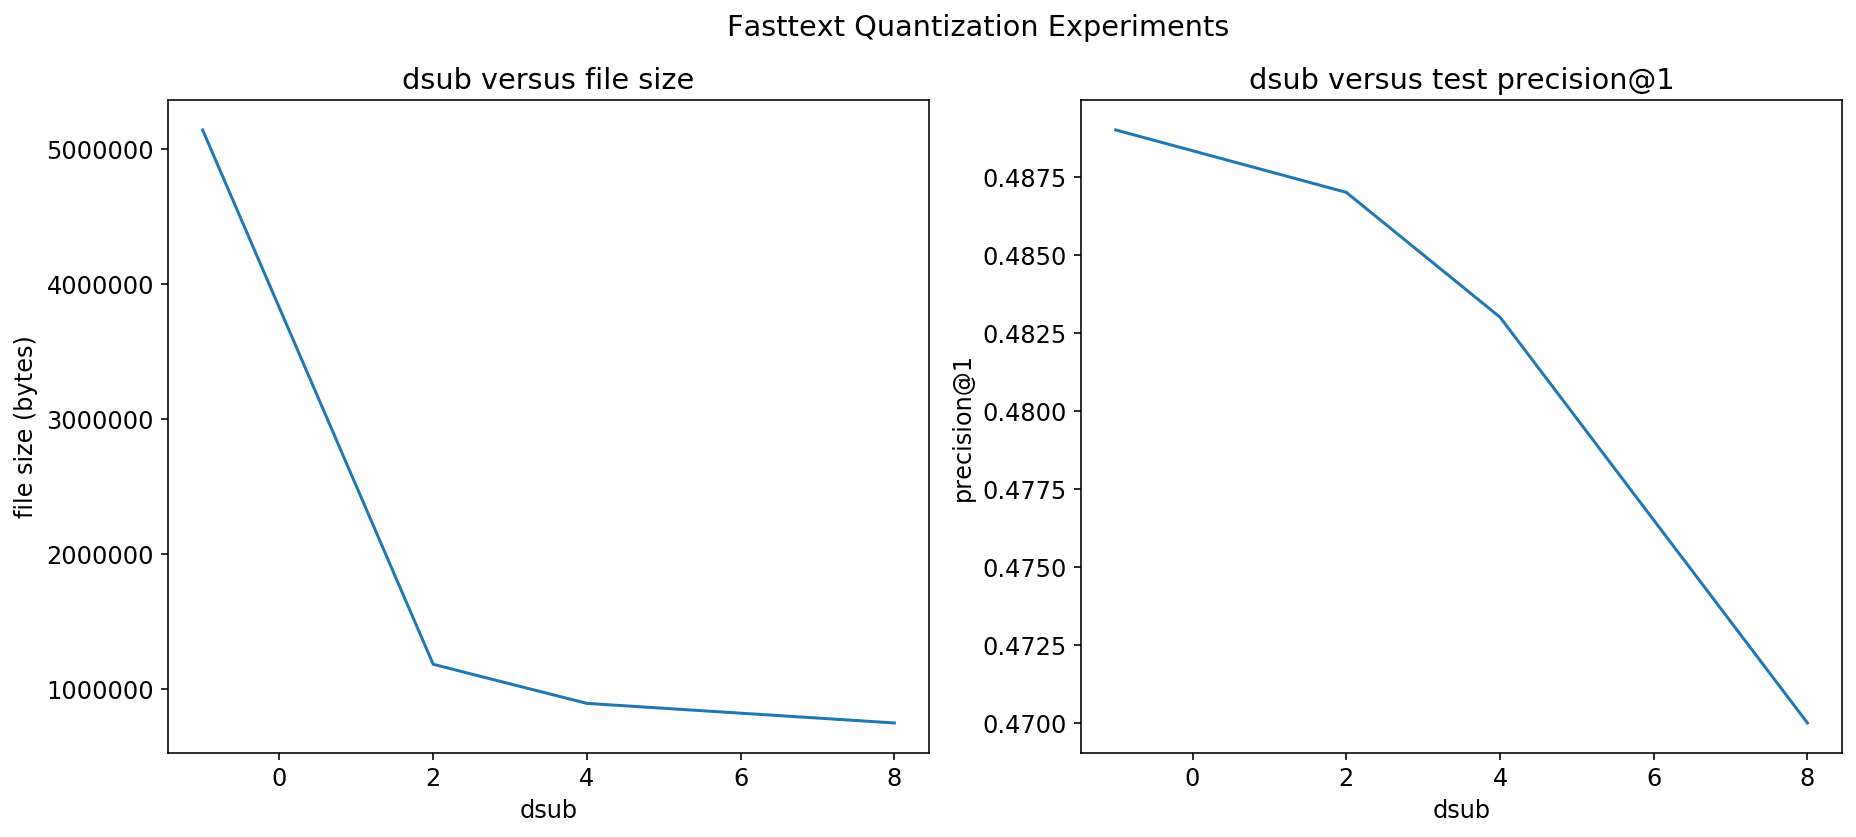

In [25]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 15, 6
plt.rcParams['font.size'] = 12

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Fasttext Quantization Experiments')

ax1.plot(df_results['dsub'], df_results['file_size'])
ax1.set_title('dsub versus file size')
ax1.set_xlabel('dsub')
ax1.set_ylabel('file size (bytes)')

ax2.plot(df_results['dsub'], df_results['test_precision@1'])
ax2.set_title('dsub versus test precision@1')
ax2.set_xlabel('dsub')
ax2.set_ylabel('precision@1')

plt.show()

The `.quantize` method also provide other options that we did not use here such as:

- Whether to quantize the output matrix, `qout`
- Whether to retrain the model's vector after doing the quantization, `retrain`.

Here we also list down the other compression tidbits from the original paper.

- **Quantize the Norm** fasttext has a parameter `qnorm` to normalize of the vector and also quantize that norm. This often times leads to a lesser drop in accuracy.
- **Retrain after Quantization:** This suggests a bottom-up learning strategy where we first quantize the input matrix, then retrain and quantize the output matrix (the input matrix being frozen).
- **Vocabulary Pruning:** Upon training the model, we can remove features that do not play a large role in the model. For each document, we verify if it is already covered by a retained feature and, if not, we add the feature with the highest norm to our set of retained features. If the number of features is below some user specified threshold, we add the features with the highest norm that have not yet been picked.
- **Choice of subvectors:** We observe in practice that using $k = d/2$ subvectors, i.e., half of the components of the embeddings, works well in practice. Using less subquantizers significantly decreases the performance for a small memory gain.

## Product Quantization Recap

To wrap up, we'll do a recap of product quantization, this time using a bit more notation.

The idea behind product quantization is to compress our original matrix into compact codes, where the comparison of the compact codes approximates the comparison in the original space. In the process of doing so, we are essentially retaining the most useful information within our matrix while discarding the less-relevant ones.

We have an original matrix $\mathbf{X} = [\mathbf{x}^1, \mathbf{x}^2, ..., \mathbf{x}^d]$, where $\mathbf{x}^i \in \mathbb{R}^n$. The input matrix will first be split into $m$ distinct sub-matrix, $\mathbf{U}^j$, $1 \leq j \leq m$, each of dimension $d^* = d / m$, where $d$ should ideally be multiple of $m$.

\begin{align}
\underbrace{\mathbf{x}^1, ..., \mathbf{x}^{d^*}}_{\mathbf{U}^1}, ..., \underbrace{\mathbf{x}^{d - d^* + 1}, ..., \mathbf{x}^{d}}_{\mathbf{U}^m}
\end{align}

Then a product quantizer function, $q(\cdot)$, is defined as a concatenation of sub-quantizer.

\begin{align}
q(\mathbf{X}) = \big[q^1(\mathbf{U}^1), q^2(\mathbf{U}^2), ..., q^M(\mathbf{U}^m)\big]
\end{align}

Where each sub-quantizer, $q^j$, is usually a low complexity quantizer/clustering algorithm, such as k-means. In other words, each sub-quantizer learns a sub-codebook/sub-cluster centroids $C^j$ comprises of $k$ centroids each of size $d^*$. Then the quantizer would map an input into its respective code/centroid under each sub-matrix and the final representation would be the concatenation of $m$ centroids.

\begin{align}
\mathbf{c} = [\mathbf{c}^1, \mathbf{c}^2, ..., \mathbf{c}^m] \in C = C^1 \times C^2, ..., C^m
\end{align}

Typically, the number of cluster centroids, $k$, is set to 256 so that each code/centroid can be represented by 8 bits.

# Reference

- [Github: Nano Product Quantization (nanopq)](https://github.com/matsui528/nanopq)
- [Blog: Product Quantizers for k-NN Tutorial Part 1](http://mccormickml.com/2017/10/13/product-quantizer-tutorial-part-1)
- [Paper: A. Joulin, E. Grave, P. Bojanowski, M. Douze, H. Jegou, T. Mikolov - FastText.zip: Compressing text classification models (2016)](https://arxiv.org/abs/1612.03651)
- [Paper: H. Jegou, M. Douze, and C. Schmid. - Product quantization for nearest neighbor search (2011)](https://lear.inrialpes.fr/pubs/2011/JDS11/jegou_searching_with_quantization.pdf)